# Multiple Linear Regression on CarDekho

The CarDekho dataset contains information about used cars listed on the website of the same name.<br/>
This dataset has 301 unique entities with the following features:
- car name
- year of release
- selling price
- present price
- kilometers driven
- fuel: such as petrol or diesel
- transmission: such as manual or automatic
- owner: how many times the car changed owner

The goal of this experiment is to train a linear model to predict the present price of a car.<br/>
We will use the framework Pytorch for the matrix calculus.

In [ ]:
## import os
import sys
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Read data from csv using Pandas

In [3]:
df = pd.read_csv(os.path.join('data', 'car_data.csv'))
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


### Convert categorical variable into indicator variables

In [4]:
f_continuous = df[['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner']]
f_categorical = pd.get_dummies(df[['Fuel_Type', 'Seller_Type', 'Transmission']])
df = pd.concat([f_continuous, f_categorical], axis=1)

# Drop refundant features
df.drop(['Transmission_Automatic', 'Seller_Type_Dealer', 'Fuel_Type_CNG'], axis=1, inplace=True)
df.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,2014,3.35,5.59,27000,0,0,1,0,1
1,2013,4.75,9.54,43000,0,1,0,0,1
2,2017,7.25,9.85,6900,0,0,1,0,1
3,2011,2.85,4.15,5200,0,0,1,0,1
4,2014,4.60,6.87,42450,0,1,0,0,1


### Visualize histogram of all features

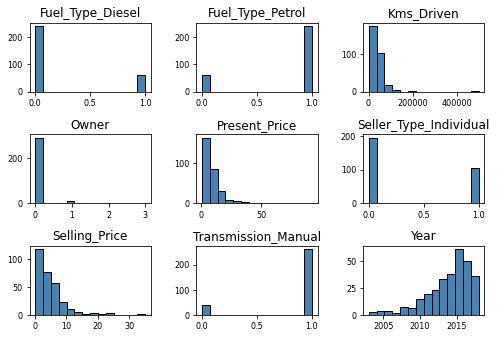

In [5]:
df.hist(bins=14, color='steelblue', edgecolor='black', linewidth=1.0, xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

### Heatmap correlation

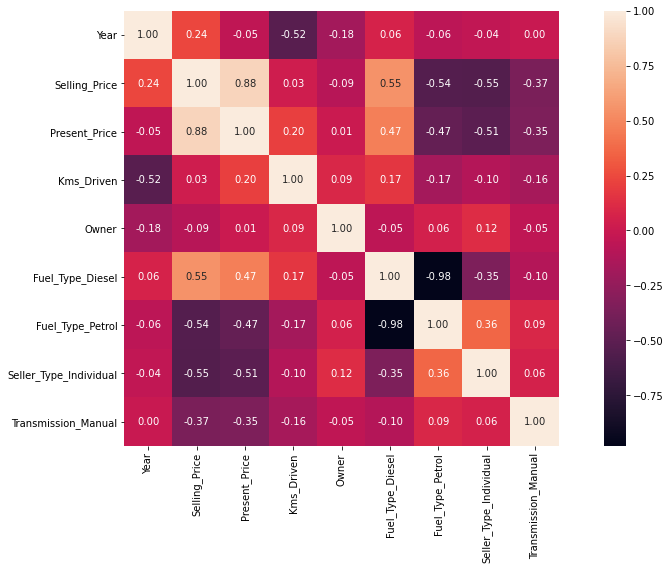

In [6]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(), square= True, annot=True, fmt='.2f')

Most of the variables are highly correlated.<br/>
As expected, the Selling_Price variable is the most correlated with the target Present_Price.

### Pairwise Plots

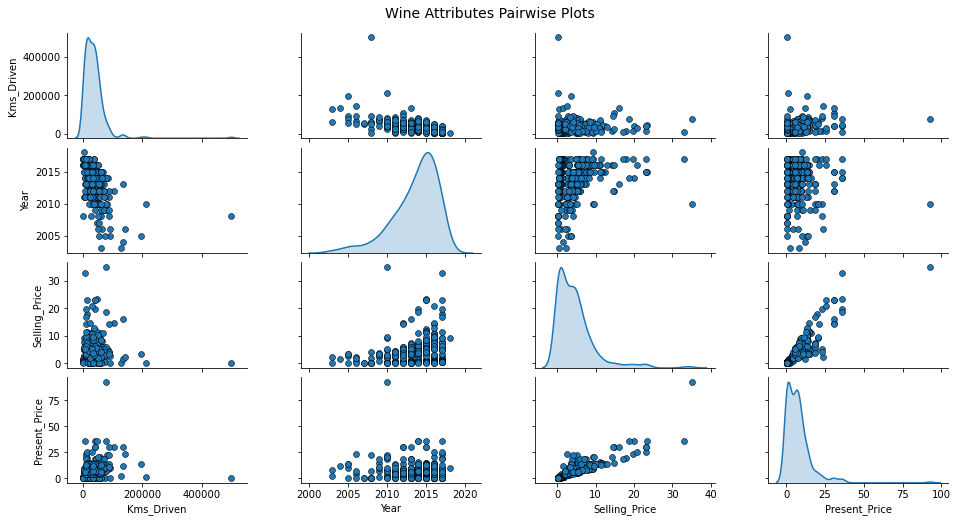

In [7]:
cols_viz = ['Kms_Driven', 'Year', 'Selling_Price', 'Present_Price']
pp = sns.pairplot(df[cols_viz], height=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots', fontsize=14)

Most of the features are highly correlated to each other.<br/>
Some outliers are present but as there is very few, we will keep them in the training set.

### Make train test split

In [8]:
# Separate the target from the dataFrame
Y = df['Selling_Price']
X = df.drop('Selling_Price', axis=1)

In [9]:
X_t = torch.from_numpy(X.to_numpy()).float()
Y_t = torch.from_numpy(Y.to_numpy()).float().unsqueeze(1)
X_train, X_test, Y_train, Y_test = train_test_split(X_t, Y_t, test_size=0.33, random_state=42)

### Train multi-variable linear regression
Training a linear model using least square regression is equivalent to minimize the mean squared error:

$
\begin{align}
\text{MSE} &= \frac{1}{n}\sum_{i=1}^{n}{||\hat{y}_i - y_i ||_{2}^{2}} \\
&= \frac{1}{n}\sum_{i=1}^{n}{||\boldsymbol{X}\boldsymbol{w} - y_i ||_2^2}
\end{align}
$

where $n$ is the number of samples, $\hat{y}$ is the predicted value of the model and $y$ is the true target.<br/>
The prediction $\hat{y}$ is obtained by matrix multiplication between the input $\boldsymbol{X}$ and the weights of the model $\boldsymbol{w}$.<br/>

Minizing the $\text{MSE}$ can be achieved by solving the gradient of this equation equals to zero in regards to the weights $\boldsymbol{w}$:

$
\begin{align}
\nabla_{\boldsymbol{w}}\text{MSE} &= 0 \\
(\boldsymbol{X}^\top \boldsymbol{X})^{-1}\boldsymbol{X}^\top \boldsymbol{y} &= \boldsymbol{w}
\end{align}
$

For more information on how to find $\boldsymbol{w}$ please visit the section "Linear Least Squares" of the following link:<br/> https://en.wikipedia.org/wiki/Least_squares#:~:text=The%20linear%20least%2Dsquares%20problem,is%20similar%20in%20both%20cases.

In [10]:
def add_ones_col(X):
    x_0 = torch.ones((X.shape[0],), dtype=torch.float32).unsqueeze(1)
    X = torch.cat([x_0, X], dim=1)
    return X

def multi_linear_reg(X, y):
    # Add a column of ones to X in order to agregate the bias to the input matrices
    X = add_ones_col(X)
    Xt_X = X.T.mm(X)
    Xt_y = X.T.mm(y)

    Xt_X_inv = Xt_X.inverse()
    w = Xt_X_inv.mm(Xt_y)
    return w

def prediction(X, w):
    X = add_ones_col(X)
    return X.mm(w)

In [11]:
# Fit the training set into the model to get the weights
w = multi_linear_reg(X_train, Y_train)

# Predict using matrix multiplication with the weights
Y_pred_train = prediction(X_train, w)
Y_pred_test = prediction(X_test, w)

### Compute prediction error

In [12]:
def mse(Y_true, Y_pred):
    error = Y_pred - Y_true
    return (error.T.mm(error) / Y_pred.shape[0]).item()

def mae(Y_true, Y_pred):
    error = Y_pred - Y_true
    return error.abs().mean().item()

In [13]:
mse_train = mse(Y_train, Y_pred_train)
mae_train = mae(Y_train, Y_pred_train)
print('MSE Train:\t', mse_train)
print('MAE Train:\t', mae_train, end='\n\n')

mse_test = mse(Y_test, Y_pred_test)
mae_test = mae(Y_test, Y_pred_test)
print('MSE Test:\t', mse_test)
print('MAE Test:\t', mae_test, end='\n\n')

print('Mean of the present price: ' + str(df['Present_Price'].mean()))

MSE Train:	 2.808985471725464
MAE Train:	 1.1321566104888916

MSE Test:	 3.7205495834350586
MAE Test:	 1.2941011190414429

Mean of the present price: 7.628471760797344


The model has an error of 1.29 on average on the training test.<br/>
Not bad for a linear model, taking into consideration that the mean of the present price is 7.62

### Principal component analysis visualization
In this section, we will use PCA to reduce the number of feature to two, in order to visualize the plane of the linear regressor.

In [14]:
# PCA can be implemented using the n principal components of the covariance matrix
def cov(A):
    A -= A.mean(dim=0, keepdim=True)
    fact = 1.0 / (A.shape[0] - 1)
    cov = fact * A.T.mm(A)
    return cov

def pca(A, target_dim=2):
    cov_a = cov(A)
    
    # We could have been using an eigen decomposition here because the covariance matrix is always squared
    # but singular value decomposition does also the trick if we take the right singular vectors
    # and perform a matrix multiplication to the right.
    U, S, V = torch.svd(cov_a)
    transform_mat = V[:, :target_dim]
    A_reduce = A.mm(transform_mat)
    return A_reduce, transform_mat

In [15]:
X_test_pca, _ = pca(X_test, target_dim=2)
X_train_pca, _ = pca(X_train, target_dim=2)

Here we recreate the prediction plane using three points of the prediction.<br/>
More info at this url:<br/>
http://kitchingroup.cheme.cmu.edu/blog/2015/01/18/Equation-of-a-plane-through-three-points/

In [16]:
points = torch.cat([X_test_pca[:3], Y_pred_test[:3]], axis=1)
v1 = points[2, :] - points[0, :]
v2 = points[1, :] - points[0, :]
cp = torch.cross(v1, v2)
a, b, c = cp
d = cp.dot(points[2, :])

min_mesh_x = min(X_test_pca[:, 0].min(), X_train_pca[:, 0].min())
max_mesh_x = max(X_test_pca[:, 0].max(), X_train_pca[:, 0].max())
min_mesh_y = min(X_test_pca[:, 1].min(), X_train_pca[:, 1].min())
max_mesh_y = max(X_test_pca[:, 1].max(), X_train_pca[:, 1].max())

mesh_x = np.linspace(min_mesh_x, max_mesh_x, 25)
mesh_y = np.linspace(min_mesh_y, max_mesh_y, 25)
mesh_xx, mesh_yy = np.meshgrid(mesh_x, mesh_y)

mesh_zz = (d - a * mesh_xx - b * mesh_yy) / c

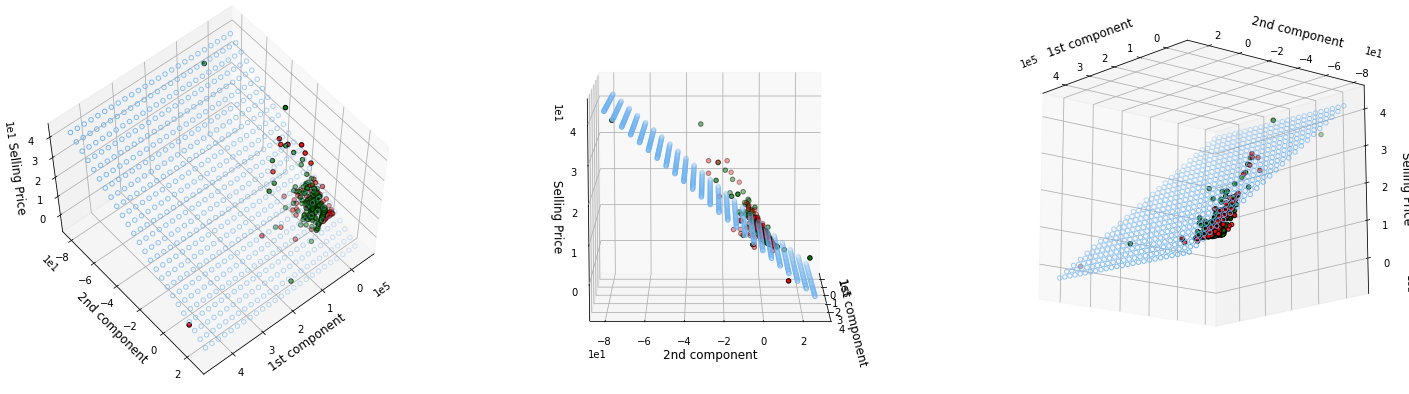

In [17]:
fig = plt.figure(figsize=(25,7))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')
axes = [ax1, ax2, ax3]

for ax in axes:
    ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], Y_test, color='red', edgecolor='black')
    ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], Y_train, color='green', edgecolor='black')
    ax.scatter(mesh_xx.flatten(), mesh_yy.flatten(), mesh_zz.flatten(), facecolor=(0, 0, 0, 0), s=20, edgecolor='#70b3f0')
    
    ax.set_xlabel('1st component', fontsize=12)
    ax.set_ylabel('2nd component', fontsize=12)
    ax.set_zlabel('Selling Price', fontsize=12)
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.ticklabel_format(axis="z", style="sci", scilimits=(0,0))
ax1.view_init(elev=60, azim=50)
ax2.view_init(elev=10, azim=0)
ax3.view_init(elev=-15, azim=140)

As we can see, the plane is fitting pretty well the data.<br/>

### Exploratory Data Analysis
We made an attempt to discard some features based on p-value but it didn't improve the results.<br/>
More on p-value here:<br/>
https://www.statsdirect.com/help/basics/p_values.htm#:~:text=The%20P%20value%2C%20or%20calculated,the%20hypothesis%20is%20being%20tested.

In [18]:
columns = X.columns
while len(columns) > 0:
    pvalues = []
    X_1 = X[columns]
    X_1 = sm.add_constant(X)
    model = sm.OLS(Y, X_1).fit()
    pvalues = pd.Series(model.pvalues[1:], index=columns)
    max_idx = np.argmax(pvalues)
    max_pval = pvalues[max_idx]
    if max_pval > 0.05:
        columns = columns.drop(columns[max_idx]) 
        print('Dropping column ' + columns[max_idx] + ', pvalue is: ' + str(max_pval))
    else:
        break

Dropping column Seller_Type_Individual, pvalue is: 0.6296373292654155
Dropping column Fuel_Type_Diesel, pvalue is: 0.11176717429491591
Dropping column Seller_Type_Individual, pvalue is: 0.05428653381413104


In [19]:
# Keeping only the columns with very low p-value
X = df[columns]

X_t = torch.from_numpy(X.to_numpy()).float()
X_train, X_test, Y_train, Y_test = train_test_split(X_t, Y_t, test_size=0.33, random_state=42)

w = multi_linear_reg(X_train, Y_train)

Y_pred_train = prediction(X_train, w)
Y_pred_test = prediction(X_test, w)

mse_train = mse(Y_train, Y_pred_train)
mse_test = mse(Y_test, Y_pred_test)
print('MSE Train:\t', mse_train)
print('MSE Test:\t', mse_test)

MSE Train:	 3.4574925899505615
MSE Test:	 3.8332533836364746


### Conclusion

A linear regression can perform pretty well if the data are highly correlated.<br/>
The pvalue is not always a good indicator for feature selection.